# Introduction Lesson 6 & 7: Object detection
- Video >> https://www.youtube.com/watch?v=Z0ssNAbe81M
- wiki >> http://forums.fast.ai/t/part-2-lesson-8-wiki/13556
- Lesson notes >> https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-8-5ae195c49493

The main topic of these 2 lessons is object detection, which means getting a model to draw a box around every key object in an image, and label each one correctly. You may be surprised to discover that we can use transfer learning from an <b>ImageNet</b> classifier that was never even trained to do detection! There are two main tasks: 
- find and localize the objects,
- and classify them

we’ll use a single model to do both these at the same time. Such multi-task learning generally works better than creating different models for each task—which many people find rather counter-intuitive. 

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/PPT1.png" width="80%">

# Lesson 6 : Detect and Classify the biggest object
<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/PPT2.png" width="80%">

<b>In this lesson, we are going to apprehend gradually this detection and classification task. As explained by JH, instead of trying to solve the big problem, it is rather easier to decompose into sub tasks or start from something simple, then, step by step, increase the complexity until we reach our final objective</b>
So, we are going to follow these steps:
- Classify the biggest object
- Predict Bounding box of biggest object
- Put all together to predict and classify the biggest object

In [1]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-9pfwv6jj
  Cloning https://github.com/valeoai/dl_utils.git to /tmp/pip-req-build-0_pnieie
Requirement already up-to-date: imageio in /usr/local/lib/python3.6/dist-packages (2.4.1)
  Running setup.py bdist_wheel for Keras ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbmwbr_n/wheels/da/a4/7e/6b7bd9af18cc2e23b8dd5ed6de07a7e13bd80a17214eb88932
  Running setup.py bdist_wheel for dl-utils ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbmwbr_n/wheels/71/ad/e4/ef0ed3b20fc1828e7eb4b7fddc4342ae6a7672d62fa2b89c6a
Successfully built Keras dl-utils
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Found existing installation: dl-utils 0.1
    Uninstalling dl-utils-0.1:
      Successfully uninstalled dl-utils-0.1


In [2]:
import keras
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

One you download and unzip your dataset, your folder will look like this:

In [0]:
import os
if not os.path.isdir('./VOCdevkit/'):
    ! wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    ! tar -xf VOCtrainval_06-Nov-2007.tar
    ! wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    ! unzip -q PASCAL_VOC.zip -d VOCdevkit/VOC2007
    ! mv VOCdevkit/VOC2007/PASCAL_VOC/pascal_train2007.json VOCdevkit/VOC2007/pascal_train2007.json 
    ! rm -Rf VOCdevkit/VOC2007/PASCAL_VOC
      
      

In [4]:
from pathlib import Path

PATH = Path('VOCdevkit/VOC2007/')
for i in PATH.iterdir(): print(i)
    
JPEGS = PATH/'JPEGImages'

VOCdevkit/VOC2007/SegmentationClass
VOCdevkit/VOC2007/JPEGImages
VOCdevkit/VOC2007/pascal_train2007.json
VOCdevkit/VOC2007/ImageSets
VOCdevkit/VOC2007/Annotations
VOCdevkit/VOC2007/SegmentationObject


so, you have:
- <kbd>JPEGImages</kbd> folder containing all the images
- <kbd>Annotations</kbd> folder containing all the annotation, one XML annotation file per image file

The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version

In [5]:
import json

BD = json.load((PATH/'pascal_train2007.json').open()) # it loads a dictionary

print('the dictionary of keys: ',BD.keys())

the dictionary of keys:  dict_keys(['images', 'type', 'annotations', 'categories'])


In [6]:
# Then, we can acces to the image
BD['images'][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [7]:
# The annotations
BD['annotations'][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [8]:
# and all category
BD['categories']

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

Finally, we want to create a dictionary to make cross reference between images and their annotation! Here, we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [9]:
import collections

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# we convert categories into dictionary
data_category = dict((o['id'],o['name']) for o in BD['categories']) # all the categories
data_filename = dict((o['id'],o['file_name']) for o in BD['images']) # image id to image filename
data_ids = [o['id'] for o in BD['images']] # list of all the image IDs

annotations = collections.defaultdict(lambda:[])
for o in BD['annotations']:
    if not o['ignore']:
        bb = o['bbox']
        bb = hw_bb(bb)
        annotations[o['image_id']].append((bb,o['category_id']))
        
print('we have',len(BD['annotations']),'annotations')

we have 7844 annotations


## some convenient display functions

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)    
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], data_category[c], sz=16)
        
def draw_idx(i):
    im_a = annotations[i]
    im = image.imread(JPEGS/data_filename[i])
    draw_im(im, im_a)    

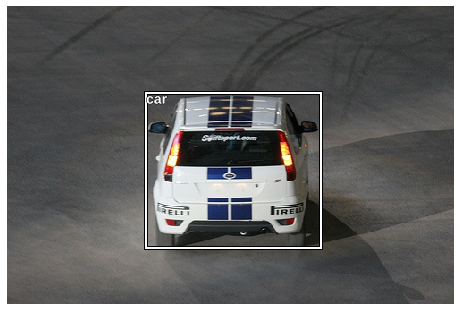

In [11]:
im = image.imread(JPEGS/data_filename[data_ids[0]])
    
ax = show_img(im)
bbox = annotations[data_ids[0]][0][0]
clas_id = annotations[data_ids[0]][0][1]
bbox = bb_hw(bbox)

draw_rect(ax, bbox)
draw_text(ax, bbox[:2], data_category[clas_id])    

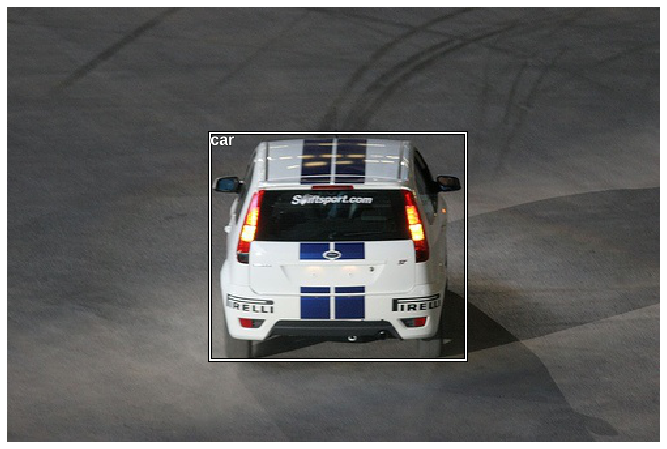

In [12]:
draw_idx(12)

## Step 1: Largest item classifier

We are going to create a classifier to predict the class of the biggest object in the image. 
For that purpose, we need to structure our learning data in a scalable manner as we will, step by step, increase the complexity of our task.

So, there are plenty of way to do that, but in Fast.ai, they use a csv file to list all images/labels instead of creating a new directory and copying inside all the needed data. For sure, it sounds better than recreating a folder and copying all the need images and labels... not really convenient, neither scalable. And finally, they have this nice function to train directly from a CSV file. 

In August 2018, Keras came with a super usefull function called <kbd>flow_from_dataframe</kbd>!!! Great, no more code to do, it is a method from <kbd>ImageDataGenerator</kbd>, and uses same properties, that is to say we can even do Data AUgmentation!

So, before doing anything with the data, that is to say jump to the conclusion, we have first to figure out how we will provide the data to our network. As we said before, Keras can use Dataframe to represent the data.

What do we put them in our dataframe? We want for each image to have a classification tag. Sounds pretty easy, right?

So,it's supposed to look like this

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/dataframe.png" width="30%">

Let's do it now!

### Pandas

We said bebore that we were going to use CSV files. Actually we will use dataframe to list all of our data.

<kbd>Pandas</kbd> lib is the standard lib to create CSV file.

In [13]:
import pandas as pd

def get_largest_annotation(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]


filename=[]
C=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    C.append(data_category[get_largest_annotation(annotation)[1]])
    
df = pd.DataFrame({'filename': filename, 'class': C}, columns=['filename','class'])

df[:5]

filename      class
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

### Split our data into training and validation set

In [0]:
# create a training and validation set

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))
    
    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))
    
    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

The easiest way to do Data Augmentation is to create an <kbd>ImageDataGenerator</kbd> and specify the transformation properties. Be carefull, remember that the data needs to be preprocessed to be compatible with the model used (VGG16). 

In [15]:
# our batch size
bs=32
# define the size of our input data
sz=224

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True) 

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_batches = train_datagen.flow_from_dataframe(df_train, 
                                                  JPEGS, 
                                                  x_col='filename', 
                                                  y_col='class', 
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None, 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=True)



valid_batches = valid_datagen.flow_from_dataframe(df_valid, 
                                                  JPEGS, 
                                                  x_col='filename', 
                                                  y_col='class', 
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=list(train_batches.class_indices), 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=False)

NbClasses = len(train_batches.class_indices)

Found 1750 images belonging to 20 classes.
Found 751 images belonging to 20 classes.


### 1.2: Create our model

Now, we need a model. Similar as before, we are going to use a model from <kbd>keras.application</kbd>. This time, it will be a VG16 model.

In [32]:
net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
        
# we add our classification layer
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NbClasses, activation='softmax', name='softmax')(x)
model = Model(inputs=net.input, outputs=output_layer)

58892288/58889256 [==============================] - 2s 0us/step


### 1.3: Define an optimizer and a Loss function

In [0]:
epochs = 20

opt = Adam(lr=1e-4)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

### 1.4: It is time to train now

Epoch 1/20
54/54 [==============================] - 41s 766ms/step - loss: 12.4010 - acc: 0.1619 - val_loss: 10.0952 - val_acc: 0.3288
Epoch 2/20
54/54 [==============================] - 39s 719ms/step - loss: 9.6072 - acc: 0.3493 - val_loss: 8.7616 - val_acc: 0.4117
Epoch 3/20
54/54 [==============================] - 37s 693ms/step - loss: 9.0950 - acc: 0.3815 - val_loss: 8.4893 - val_acc: 0.4312
Epoch 4/20
54/54 [==============================] - 37s 686ms/step - loss: 8.2043 - acc: 0.4283 - val_loss: 7.1332 - val_acc: 0.5035
Epoch 5/20
54/54 [==============================] - 37s 682ms/step - loss: 7.3894 - acc: 0.4741 - val_loss: 6.5129 - val_acc: 0.5424
Epoch 6/20
54/54 [==============================] - 36s 676ms/step - loss: 6.7411 - acc: 0.5230 - val_loss: 6.2978 - val_acc: 0.5591
Epoch 7/20
54/54 [==============================] - 36s 674ms/step - loss: 6.2773 - acc: 0.5507 - val_loss: 5.8847 - val_acc: 0.5981
Epoch 8/20
54/54 [==============================] - 36s 670ms/step 

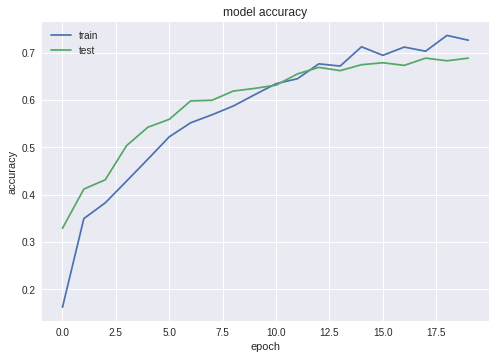

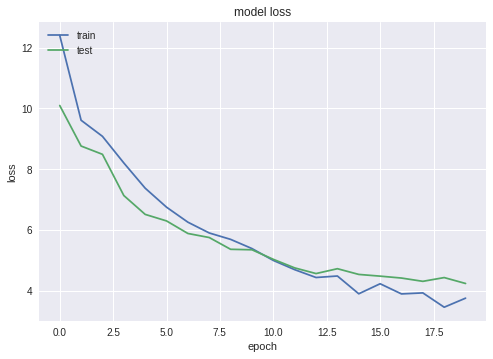

In [34]:
history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1.5: unfreeze couple of layers

In [0]:
#unfreeze initial layers
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True

Epoch 1/10
54/54 [==============================] - 40s 741ms/step - loss: 3.5701 - acc: 0.7301 - val_loss: 4.1499 - val_acc: 0.7065
Epoch 2/10
54/54 [==============================] - 38s 709ms/step - loss: 3.0163 - acc: 0.7657 - val_loss: 4.0529 - val_acc: 0.7051
Epoch 3/10
54/54 [==============================] - 38s 710ms/step - loss: 3.0489 - acc: 0.7675 - val_loss: 3.9843 - val_acc: 0.7107
Epoch 4/10
54/54 [==============================] - 38s 708ms/step - loss: 3.1311 - acc: 0.7602 - val_loss: 4.0116 - val_acc: 0.6982
Epoch 5/10
54/54 [==============================] - 38s 705ms/step - loss: 3.2024 - acc: 0.7464 - val_loss: 4.0035 - val_acc: 0.6968
Epoch 6/10
54/54 [==============================] - 38s 698ms/step - loss: 2.8226 - acc: 0.7618 - val_loss: 3.8574 - val_acc: 0.7038
Epoch 7/10
54/54 [==============================] - 38s 695ms/step - loss: 2.9505 - acc: 0.7538 - val_loss: 3.7719 - val_acc: 0.7065
Epoch 8/10
54/54 [==============================] - 37s 691ms/step - 

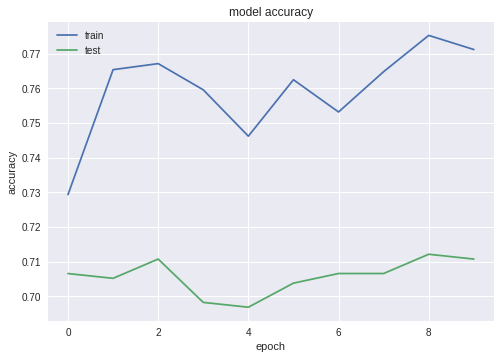

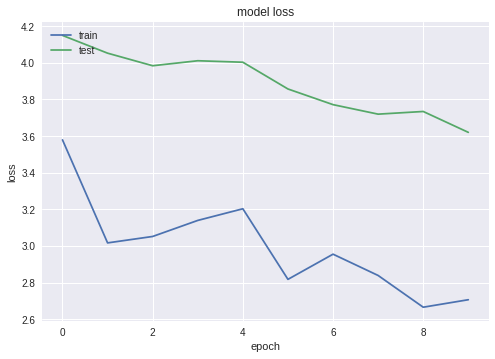

In [36]:
epochs = 10

opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1.6: Check the result

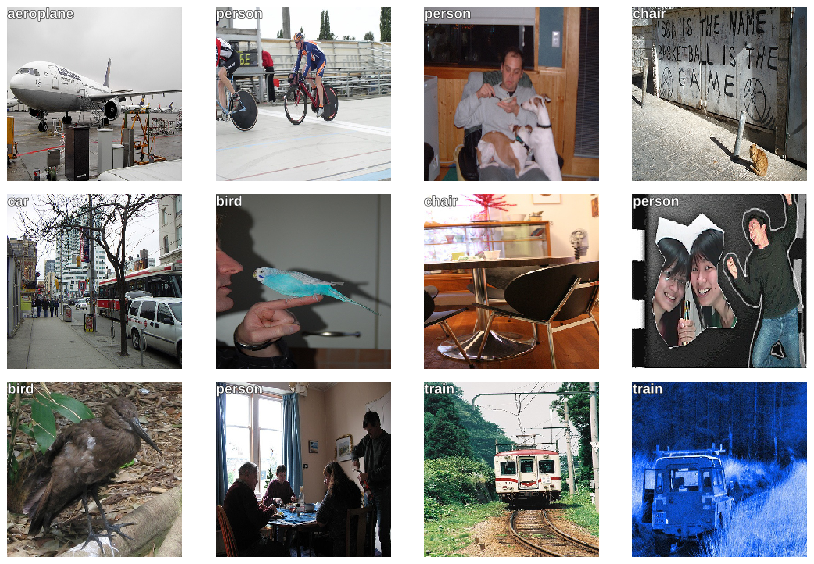

In [37]:
from dlutils import unpreprocess

class_name = list(valid_batches.class_indices)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y = valid_batches.next()
    image = x[0]
    proba = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)
    class_id = np.argmax(proba)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), class_name[class_id])

plt.tight_layout()

It's doing a pretty good job of classifying the largest object, 74% of accuracy!

## Step 2: Bbox regression

### 2.1: The Data

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. 

In [17]:
# we create this time our data frame with the box coordiantes

filename=[]
bbox=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    bbox.append(get_largest_annotation(annotation)[0])
    
df = pd.DataFrame({'filename': filename, 'bbox': bbox}, columns=['filename','bbox'])

df[:5]

filename                 bbox
0  000012.jpg  [96, 155, 269, 350]
1  000017.jpg   [77, 89, 335, 402]
2  000023.jpg     [1, 2, 461, 242]
3  000026.jpg  [124, 89, 211, 336]
4  000032.jpg  [77, 103, 182, 374]

In [0]:
# create a training and validation set
df_train, df_valid = Split_Train_Valid(df,0.7)

Unfortunately, we can t really use as before the <kbd>flow_from_dataframe</kbd> function. There are several reasons, but the most important one is that we need to resize the image to fit to our input tensor and as a consequence, bounding boxes should be resized too!

We could think to create our own preprocessing function and pass it to the Generator but it would have access to the image only, not its label!
We could also load all the data into memory because it s only 224*224 images, so the memory footprint would be quite reasonable. Then, we could use directly the <kbd>fit</kbd> function instead of <kbd>fit_generator</kbd>

So, it is a blessing in disguise that we have to create our own Generator. We will learn something new today! 

In [0]:
class DataFrame_Generator(keras.utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self, df, folder,preprocess_fct,batch_size=32, dim=(32,32), shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.folder = folder
    
        # Load the dataframe
        # the database is not so big, especially when resized in 224*224.
        # so we have either the option to load images online for each batch or
        # we can load all image at once 
        self.df = df
        self.n = len(df)            
        self.nb_iteration = int(np.floor(self.n  / self.batch_size))
        
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.zeros((self.batch_size,4))

        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img = Image.open(self.folder/self.df['filename'][ID])
            bb = self.df['bbox'][ID]
                              
            width, height = img.size
            RatioX = width/self.dim[0]
            RatioY = height/self.dim[1]
                                                        
            img = np.asarray(img.resize(self.dim))
            bb = [bb[0]/RatioY,bb[1]/RatioX,bb[2]/RatioY,bb[3]/RatioX]
                                                 
            X[i,] = self.preprocess_fct(np.asarray(img))
            Y[i] = bb

        return X, Y 

In [0]:
train_gen = DataFrame_Generator(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = DataFrame_Generator(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

Let's have a look to an example

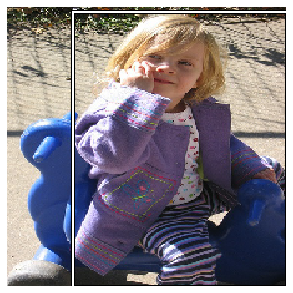

In [42]:
x,y = next(iter(train_gen))

ax = show_img(unpreprocess(x[0],'None','None'), figsize=(5,10))
draw_rect(ax, bb_hw(y[0]))

### 2.2: The model

Here, we want to predict the position of the bouding box.
Actually, we expect our model to predict 4 values: this is a regression problem.

As the difference with Classification, we do not expect a probability but real position values! Our network will be the same as before (especially because we want to share latter the feature encoder part) but instead of adding a classifcation layer with a SoftMax or Sigmoid function (to provide a probability) we only need to add a linear layer

In [0]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
        
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='linear', name='linear')(x)
model = Model(inputs=net.input, outputs=output_layer)   

### 2.3: The optimizer

Our optimizer will optimize the task our model is designed for. Compared to before, we used a Cross-entropy as our Loss function to predict Category. Now, as we want to predict continuous values, we are going to use L1 or L2 Loss

In [0]:
optimizer=Adam(lr=1e-4)

model.compile(optimizer=optimizer,loss='mean_absolute_error', metrics=['accuracy'])

### 2.4: It's time to train

Epoch 1/15
54/54 [==============================] - 24s 450ms/step - loss: 65.3990 - acc: 0.4311 - val_loss: 42.1059 - val_acc: 0.6060
Epoch 2/15
54/54 [==============================] - 23s 430ms/step - loss: 42.5234 - acc: 0.5880 - val_loss: 37.3841 - val_acc: 0.6345
Epoch 3/15
54/54 [==============================] - 23s 429ms/step - loss: 37.9737 - acc: 0.6163 - val_loss: 35.2404 - val_acc: 0.6562
Epoch 4/15
54/54 [==============================] - 23s 430ms/step - loss: 35.0254 - acc: 0.6360 - val_loss: 34.0100 - val_acc: 0.6916
Epoch 5/15
54/54 [==============================] - 23s 430ms/step - loss: 32.8997 - acc: 0.6499 - val_loss: 32.9645 - val_acc: 0.6875
Epoch 6/15
54/54 [==============================] - 23s 430ms/step - loss: 30.8683 - acc: 0.6678 - val_loss: 32.5543 - val_acc: 0.6902
Epoch 7/15
54/54 [==============================] - 23s 431ms/step - loss: 29.7937 - acc: 0.6707 - val_loss: 32.0823 - val_acc: 0.7052
Epoch 8/15
54/54 [==============================] - 23s

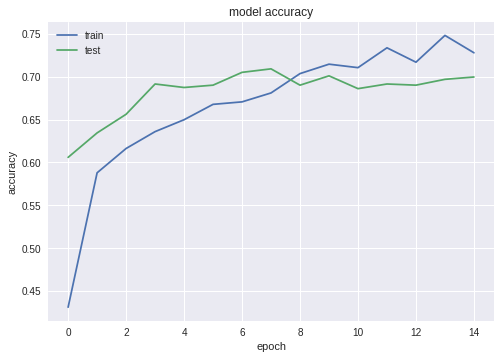

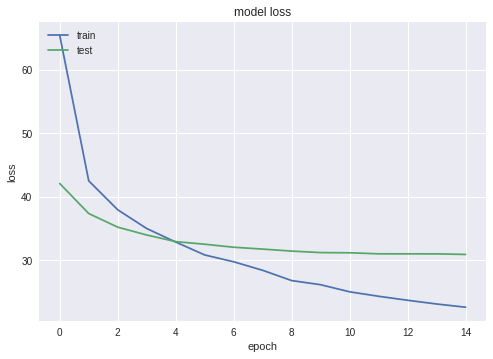

In [45]:
epochs = 15

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2.5: unfreeze couple of layers

Epoch 1/10
54/54 [==============================] - 13s 238ms/step - loss: 40.5993 - acc: 0.6377 - val_loss: 31.0385 - val_acc: 0.6671
Epoch 2/10
54/54 [==============================] - 11s 201ms/step - loss: 29.5912 - acc: 0.6997 - val_loss: 29.6196 - val_acc: 0.7378
Epoch 3/10
54/54 [==============================] - 11s 201ms/step - loss: 26.6288 - acc: 0.7269 - val_loss: 27.8212 - val_acc: 0.7283
Epoch 4/10
54/54 [==============================] - 11s 201ms/step - loss: 24.4044 - acc: 0.7598 - val_loss: 27.8414 - val_acc: 0.7052
Epoch 5/10
54/54 [==============================] - 11s 203ms/step - loss: 21.8674 - acc: 0.7639 - val_loss: 28.1618 - val_acc: 0.7296
Epoch 6/10
54/54 [==============================] - 11s 204ms/step - loss: 20.4772 - acc: 0.7853 - val_loss: 28.7631 - val_acc: 0.7364
Epoch 7/10
54/54 [==============================] - 11s 201ms/step - loss: 19.2398 - acc: 0.7894 - val_loss: 27.7161 - val_acc: 0.7391
Epoch 8/10
54/54 [==============================] - 11s

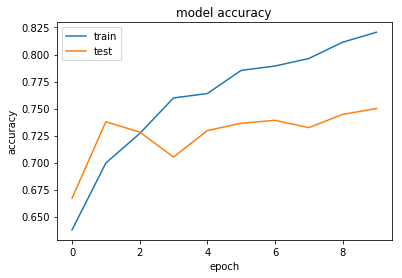

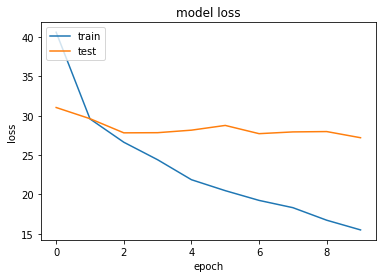

In [0]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
model.compile(optimizer=optimizer,loss='mean_absolute_error', metrics=['accuracy'])    

epochs = 10

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2.6: Check the result

NameError: ignored

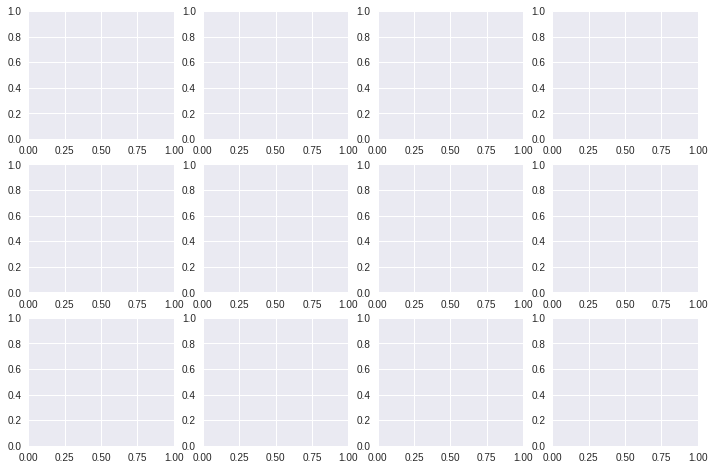

In [19]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y = next(iter(valid_gen))
    image = x[i]
    bb = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)

    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb[0]))

plt.tight_layout()

## Step 3: Single object detection

We have now to combine the two individual tasks of classification and detection we have developped bedore. We know that independently, it works. Therefore, if we modify accordingly our data, our model, our Loss function... it shoudl work too!

let's go...

### 3.1: The Data

The data is still the image plus a tuple containing the bounding box coordinates and the category

In [0]:
df = pd.DataFrame({'filename': filename, 'cat':C, 'bbox': bbox}, columns=['filename','cat','bbox'])
df_train, df_valid = Split_Train_Valid(df,0.7)

We put an updated version of the DataFrame Generator in the Utils lib

In [0]:
from dlutils import GeneratorSingleObject

train_gen = GeneratorSingleObject(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = GeneratorSingleObject(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

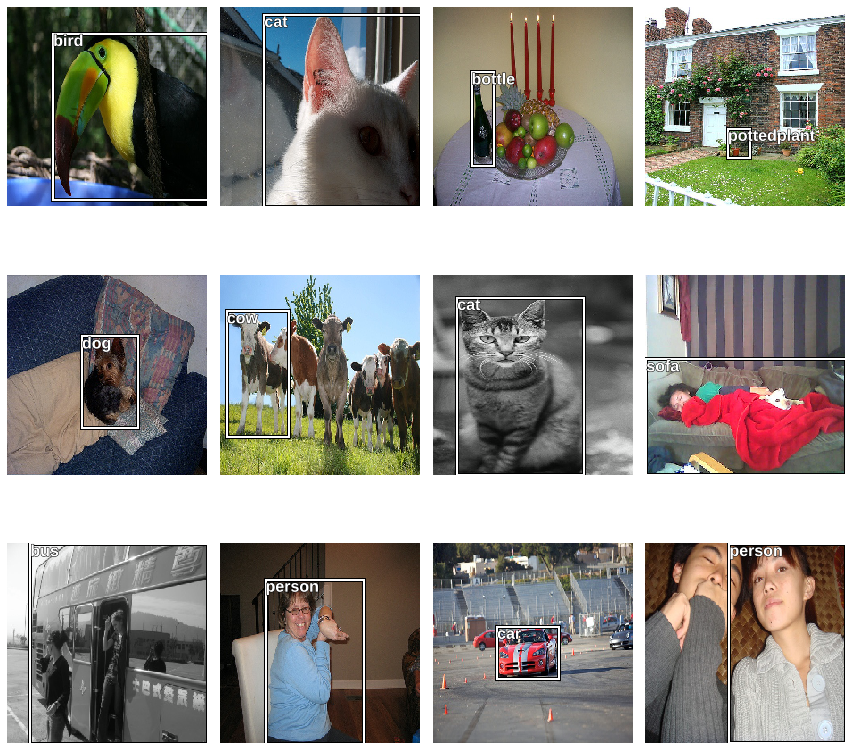

In [24]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(train_gen))
    bb = y_batch[0][i]
    cat = y_batch[1][i]    
    image = x_batch[i]

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

### 3.2: The model

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [0]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
 
y = net.output
y = Flatten()(y)
y = Dropout(0.5)(y)

# branch for the regression --> BBox
output_layer_bbox = Dense(4, activation='linear', name='layer_bbox')(y)

# Branch for the classification --> Category
output_layer_class = Dense(train_gen.NbClasses, activation='softmax', name='layer_class')(y)

model = Model(inputs=net.input, outputs=[output_layer_bbox,output_layer_class])

### 3.3: The optimizer

Here, we need to combine the two Loss function for each branch.
Because each Loss will have different range, it is then better to set a weight on each of them.
We can check from the previous individual training to put the weight accordingly so that each branch has the same influence

In [0]:
optimizer=Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'], metrics=['accuracy'],loss_weights=[1., 5.])

### 3.4: Time to train

In [27]:
epochs = 20

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

print(history.history.keys())

Epoch 1/20
54/54 [==============================] - 29s 528ms/step - loss: 127.7132 - layer_bbox_loss: 64.7921 - layer_class_loss: 12.5842 - layer_bbox_acc: 0.4931 - layer_class_acc: 0.1528 - val_loss: 91.8768 - val_layer_bbox_loss: 42.0356 - val_layer_class_loss: 9.9682 - val_layer_bbox_acc: 0.6155 - val_layer_class_acc: 0.3193
Epoch 2/20
54/54 [==============================] - 23s 431ms/step - loss: 86.7859 - layer_bbox_loss: 41.7155 - layer_class_loss: 9.0141 - layer_bbox_acc: 0.5909 - layer_class_acc: 0.3785 - val_loss: 79.4680 - val_layer_bbox_loss: 38.0701 - val_layer_class_loss: 8.2796 - val_layer_bbox_acc: 0.6535 - val_layer_class_acc: 0.4361
Epoch 3/20
54/54 [==============================] - 23s 431ms/step - loss: 76.2765 - layer_bbox_loss: 37.9128 - layer_class_loss: 7.6727 - layer_bbox_acc: 0.6157 - layer_class_acc: 0.4676 - val_loss: 71.4976 - val_layer_bbox_loss: 35.9825 - val_layer_class_loss: 7.1030 - val_layer_bbox_acc: 0.6726 - val_layer_class_acc: 0.5014
Epoch 4/20


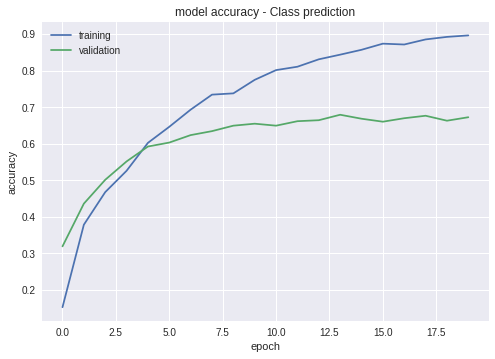

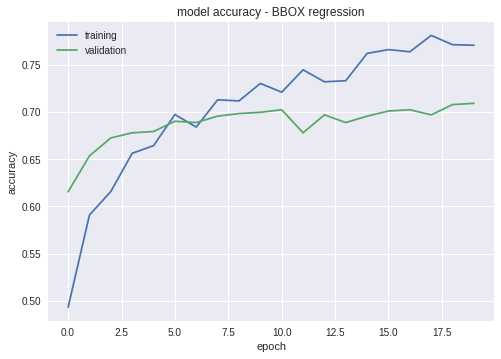

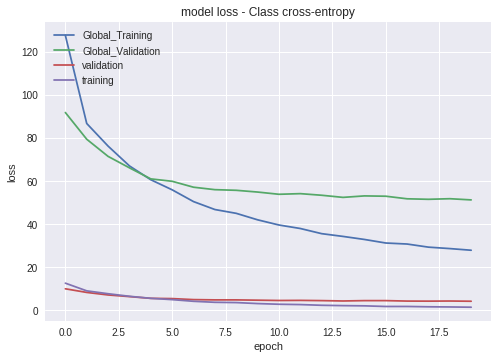

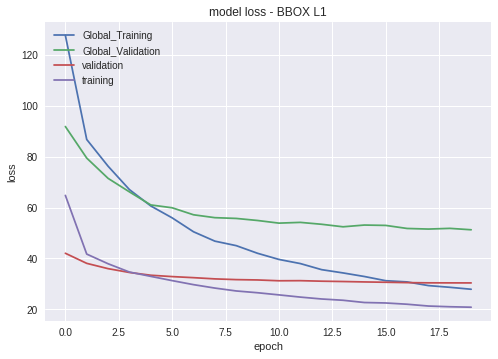

In [28]:
# summarize history for accuracy for Class
plt.plot(history.history['layer_class_acc'])
plt.plot(history.history['val_layer_class_acc'])
plt.title('model accuracy - Class prediction')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for accuracy for bbox regression
plt.plot(history.history['layer_bbox_acc'])
plt.plot(history.history['val_layer_bbox_acc'])
plt.title('model accuracy - BBOX regression')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for loss for Class
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.plot(history.history['layer_class_loss'])
plt.title('model loss - Class cross-entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

# summarize history for loss for BBOX
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.plot(history.history['layer_bbox_loss'])
plt.title('model loss - BBOX L1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

### 3.5: unfreeze few layers

In [29]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
optimizer=Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'], 
              metrics=['accuracy'],loss_weights=[1., 20.])
 

epochs = 20

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

Epoch 1/20
54/54 [==============================] - 27s 508ms/step - loss: 46.8536 - layer_bbox_loss: 20.7540 - layer_class_loss: 1.3050 - layer_bbox_acc: 0.7766 - layer_class_acc: 0.9074 - val_loss: 111.5935 - val_layer_bbox_loss: 30.1878 - val_layer_class_loss: 4.0703 - val_layer_bbox_acc: 0.7052 - val_layer_class_acc: 0.6834
Epoch 2/20
54/54 [==============================] - 26s 473ms/step - loss: 45.3876 - layer_bbox_loss: 20.1576 - layer_class_loss: 1.2615 - layer_bbox_acc: 0.7760 - layer_class_acc: 0.9074 - val_loss: 111.1248 - val_layer_bbox_loss: 29.9906 - val_layer_class_loss: 4.0567 - val_layer_bbox_acc: 0.7079 - val_layer_class_acc: 0.6821
Epoch 3/20
54/54 [==============================] - 26s 472ms/step - loss: 45.2163 - layer_bbox_loss: 20.3513 - layer_class_loss: 1.2433 - layer_bbox_acc: 0.7598 - layer_class_acc: 0.9097 - val_loss: 109.6249 - val_layer_bbox_loss: 29.7654 - val_layer_class_loss: 3.9930 - val_layer_bbox_acc: 0.7052 - val_layer_class_acc: 0.6821
Epoch 4/20

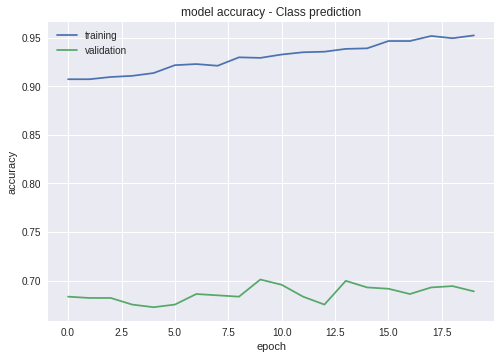

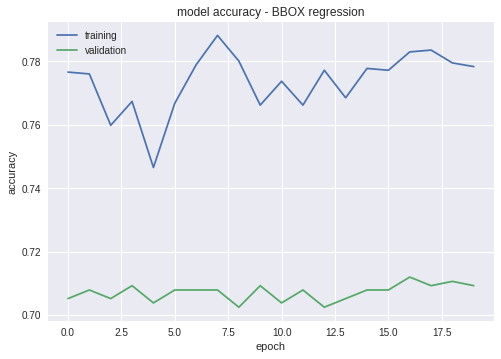

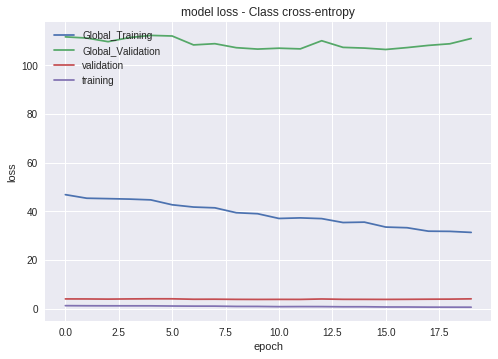

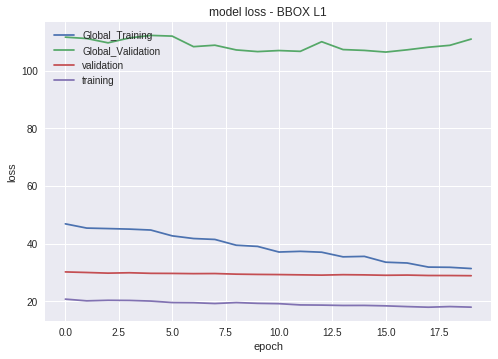

In [30]:
# summarize history for accuracy for Class
plt.plot(history.history['layer_class_acc'])
plt.plot(history.history['val_layer_class_acc'])
plt.title('model accuracy - Class prediction')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for accuracy for bbox regression
plt.plot(history.history['layer_bbox_acc'])
plt.plot(history.history['val_layer_bbox_acc'])
plt.title('model accuracy - BBOX regression')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for loss for Class
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.plot(history.history['layer_class_loss'])
plt.title('model loss - Class cross-entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

# summarize history for loss for BBOX
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.plot(history.history['layer_bbox_loss'])
plt.title('model loss - BBOX L1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

### 3.6: check our result

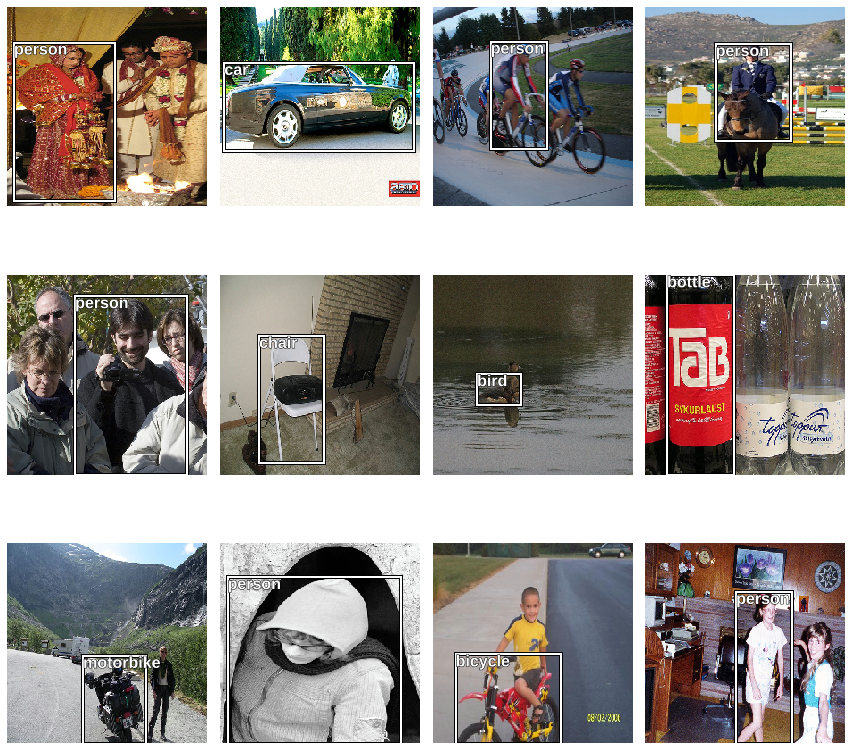

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(valid_gen))
    bb = y_batch[0][i]
    cat = y_batch[1][i]    
    image = x_batch[i]

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

# What did we learnt?

We learnt today couple of things. But still the same pattern: DATA + Loss + Model

First, we understand how crucial it is to structure our data.
Our problem becomes more and more complex, so we have first to check if our data are correct: is it the correct transformation, preprocessing, category...? everything has to be clear before we actually start the real job


Then, we know know how to tune our final layers to perform the needed task: a SoftMax for classifcation and a linear layer for Regression.

The Loss function has to be adapted to our task, that is to say, a Cross-entropy for classification and L1 or L2 Loss when we predict something continuous.

Finally, we have seen how to put all together in keras.

<b>The most important, what you have now to keep in mind, never try to solve the big task from scratch. Prefer to decompose into subtask or simple task and the, as we did, put all component together at end as soon as individual blocks work!

# Assignment

few ideas:
- implement a true class generator to use PascalVOC2009, it won't fit into memory as we did today
- implement data augmentation for bounding box. This is a bit tricky
- improve our model, try a new one...
- try with another dataset

# END